In [1]:
import numpy as np
import pandas as pd

import re #regex
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout,  LSTM, Dense, Embedding, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import Adam
import io
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences 

import pickle

from tensorflow.keras import backend as K
import random

from rouge import Rouge #https://towardsdatascience.com/introduction-to-text-summarization-with-rouge-scores-84140c64b471

import copy
import tensorflow as tf

tf.config.run_functions_eagerly(True)


from tensorflow import keras
import keras_tuner as kt
from transformers import GPT2TokenizerFast, GPT2Config, GPT2Model, TFAutoModelForCausalLM, AutoTokenizer, TFGPT2Model

print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices()))
import keras_nlp

ROUGE = Rouge()

2024-09-26 08:12:21.149022: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 08:12:21.187271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 08:12:21.187301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 08:12:21.188346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 08:12:21.194863: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using TensorFlow backend


2024-09-26 08:12:23.406332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 08:12:23.453029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 08:12:23.460410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
buffer_size = 10000
batch_size= 16
window_size= 50 
epochs= 150
embedding_dim = 200

TRAIN_AND_SAVE = True
TRAIN_AND_SAVE_TRANFORMER = True

TRAIN_TEXT= True
SEED=42
TRAIN_TOKEN = True
TUNNING = True
GENERATE_TEXT= True


translationTable = str.maketrans("áéíóúàèìòùâêîôûãõç", "aeiouaeiouaeiouaoc")

In [3]:
# import tensorflow.data as tf_data
# import tensorflow.strings as tf_strings

# keras.utils.get_file(
#     origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
#     extract=True,
# )
# dir = os.path.expanduser("~/.keras/datasets/simplebooks/")

# # Load simplebooks-92 train set and filter out short lines.
# raw_train_ds = (
#     tf_data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
#     .filter(lambda x: tf_strings.length(x) > 512)
#     .batch(batch_size)
#     .shuffle(buffer_size=256)
# )
# for x in raw_train_ds.take(1):
#     print(x)

In [4]:

DATA_CHECKPOINTS_DIR = './checkpoints'
tfrecord_filename = "train_tmp.tfrecord"
train_tmp_record_path = f'{DATA_CHECKPOINTS_DIR}/{tfrecord_filename}'

!mkdir -p {DATA_CHECKPOINTS_DIR}

In [5]:
def prepare_data(path_to_file ='./nietzsche.txt'):
    path_to_file = "./eca_de_queiros_os_maias.txt"
    
    with io.open(path_to_file, encoding='utf-8') as f:
        text = f.read().lower()

    print('corpus length:', len(text))
    text = text.translate(translationTable)

    string_check= re.compile('[^a-zA-Z.?!,:\'<>]')

    text = re.sub(string_check, ' ', (text)
                        .replace("-"," ")
                        .replace("´","'")
                        .replace("`","'")
                        .replace(","," , ")
                        .replace("s."," sao ")
                        .replace("d.","don")
                        .replace("v.","v")
                        .replace("sr.", "senhor")
                        .replace("sra.", "senhora")
                        .replace("exmo.", "exmo")
                        .replace("exma.", "exma")
                        .replace("x.", "x")
    )

    text = re.sub(' +', ' ',text)
    text = (re.sub('\.+', " . \n", text).replace("<br />"," "))

    lines_list = list()
    lines_list = text.split("\n")

    cols = ['sentences']
    df_tmp= pd.DataFrame(columns=cols)
    df_tmp["sentences"] = lines_list

    return df_tmp
complete_text= prepare_data()
complete_text

corpus length: 1266856


sentences
0      a casa que vieram habitar em lisboa , no outon...
1       apesar deste fresco nome de vivenda campestre...
2       longos anos o ramalhete permanecera desabitad...
3       em monsenhor bucarini , nuncio de sao santida...
4       este inutil pardieiro como lhe chamava vilaca...
...                                                  ...
10205   ega , ao lado , ajuntava , ofegante , atirand...
10206   a lanterna vermelha do americano , ao longe ,...
10207   e foi em carlos e em joao da ega uma esperanc...
10208   entao , para apanhar o americano , os dois am...
10209                                                   

[10210 rows x 1 columns]

In [6]:
df= prepare_data()

complete_text = ' '.join(df.sentences.values.tolist())
complete_unique_words_list = list(set(complete_text.split(' ')))
vocab_len = len(complete_unique_words_list)
display(df)
display(vocab_len)
display(complete_unique_words_list)

corpus length: 1266856


sentences
0      a casa que vieram habitar em lisboa , no outon...
1       apesar deste fresco nome de vivenda campestre...
2       longos anos o ramalhete permanecera desabitad...
3       em monsenhor bucarini , nuncio de sao santida...
4       este inutil pardieiro como lhe chamava vilaca...
...                                                  ...
10205   ega , ao lado , ajuntava , ofegante , atirand...
10206   a lanterna vermelha do americano , ao longe ,...
10207   e foi em carlos e em joao da ega uma esperanc...
10208   entao , para apanhar o americano , os dois am...
10209                                                   

[10210 rows x 1 columns]

22255

['',
 'gasta',
 'procurar',
 'seculares',
 'anjinho',
 'colera',
 'farejando',
 'desejei',
 'diabo?',
 'abismar',
 'alegraram',
 'descobre',
 'leito',
 'camara!',
 'explicaram',
 'ornavam',
 'falada!',
 'sandalo',
 'cessou',
 'gourmet',
 'efusao',
 'general',
 'inspira',
 'quente!',
 'recebido',
 'timidez',
 'recapitular',
 'parceiros',
 'dia:',
 'reclamacoes',
 'irrisoes',
 'esguias',
 'traga',
 'vivendo',
 'inaproveitado',
 'indefinida',
 'craveirote',
 'cabeca:',
 'estragada?',
 'proporcoes',
 'ruga!',
 'palestrar',
 'cronica',
 'conferiu',
 'selar',
 'bons?',
 'divagacoes:',
 'iam',
 'veneracao',
 'romanos!',
 'agasalhado',
 'cobarde!',
 'substituido',
 'cavalinhos',
 'revistas',
 'achegou',
 'regata',
 'pronunciou',
 'pescoco',
 'prato',
 'casais',
 'servir!',
 'cachenez',
 'pagando',
 'empresa',
 'social?',
 'gemia',
 'montada',
 'nuvensinhas',
 'argentino:',
 'nova!',
 'senhores?',
 'louros',
 'solteiroe',
 'viam',
 'fama',
 'faias',
 'guela',
 'ideara',
 'quarta',
 'vintista',


sentences  sent_length
1       apesar deste fresco nome de vivenda campestre...          129
3       em monsenhor bucarini , nuncio de sao santida...          210
4       este inutil pardieiro como lhe chamava vilaca...           64
5       nessa ocasiao vendera se outra propriedade d ...           53
7       eram uma antiga familia da beira , sempre pou...           57
...                                                  ...          ...
10153   parou diante do alto espelho suspenso entre a...           55
10162   passeio a cavalo no bois almoco no bignon uma...           71
10172   carlos pos tambem o chapeu: e desceram pelas ...           96
10188   tudo aceitar , o que vem e o que foge , com a...           61
10196   ja avistavam o aterro , a sua longa fila de l...           58

[1142 rows x 2 columns]

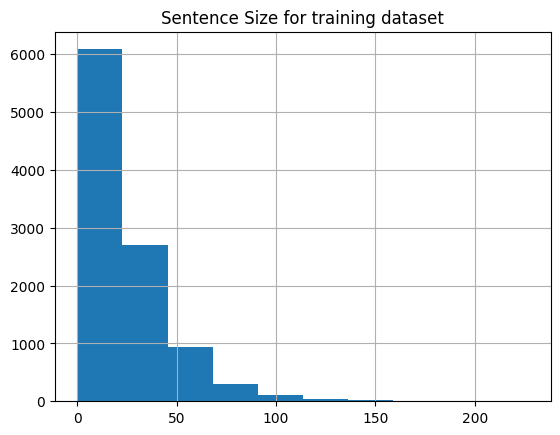

In [7]:
df["sent_length"] = df.sentences.apply(lambda x: len(x.split()))

plt.figure()
pd.Series(df.sent_length).hist()
plt.title("Sentence Size for training dataset")
df[df.sent_length>window_size]

In [8]:
df = df[df.sent_length>=5]
df

sentences  sent_length
0      a casa que vieram habitar em lisboa , no outon...           42
1       apesar deste fresco nome de vivenda campestre...          129
2       longos anos o ramalhete permanecera desabitad...           25
3       em monsenhor bucarini , nuncio de sao santida...          210
4       este inutil pardieiro como lhe chamava vilaca...           64
...                                                  ...          ...
10204   com efeito , nao vale a pena fazer um esforco...           18
10205   ega , ao lado , ajuntava , ofegante , atirand...           33
10206   a lanterna vermelha do americano , ao longe ,...           14
10207   e foi em carlos e em joao da ega uma esperanc...           29
10208   entao , para apanhar o americano , os dois am...           31

[9687 rows x 2 columns]

In [9]:
candidate_list=['data scientist tasks', 'data scientist jobs','data scientist job','data scientist, and','data engineer tasks','data engineer jobs']

def Minimum_Bayes_Risk(list_of_candidates, field = "rouge-l", candidate_reference = None):
    candidate_score = {}
    max_score = 0
    best_score_candidate= ''
    best_candidate_index = -1
    if candidate_reference == None :
        for candidate_ref in list_of_candidates:
            
            rest_of_candidates = copy.deepcopy(list_of_candidates)
            if candidate_ref in rest_of_candidates : rest_of_candidates.remove(candidate_ref)
            score = 0

            for candidate in rest_of_candidates:
                score += ROUGE.get_scores(candidate, candidate_ref)[0][field]["f"]
            
            score = score/len(rest_of_candidates)

            candidate_score[candidate_ref] = score

            if score >= max_score:
                best_score_candidate =candidate_ref
                best_candidate_index = list_of_candidates.index(candidate_ref)
                max_score = score

    else:
            
            for candidate in list_of_candidates:
                score = 0
                score = ROUGE.get_scores(candidate, candidate_reference)[0][field]["f"]
                if score >= max_score:
                    best_score_candidate =candidate_ref


    return candidate_score, best_score_candidate, best_candidate_index

candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(candidate_list)
candidate_score, best_score_candidate , best_candidate_index

({'data scientist tasks': 0.5333333283333335,
  'data scientist jobs': 0.5333333283333335,
  'data scientist job': 0.4666666616666668,
  'data scientist, and': 0.3333333283333334,
  'data engineer tasks': 0.4666666616666667,
  'data engineer jobs': 0.4666666616666667},
 'data scientist jobs',
 1)

# Getting Dataset ready and Tokenized

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_val_test = train_test_split(df,test_size=0.2,train_size=0.8)

display(df_train)
display(df_val_test)

sentences  sent_length
5678   tu nao tens visto o damaso? nunca mais me apa...           19
3996   nao temos nada capaz de dar a um rapaz um boc...           14
7831   foi ao cruges que se dirigiu , entalando o mo...           14
8357   ve que tudo isso de fidalguia , pergaminhos ,...           33
1617   olavia , depois de ter servido em lisboa , na...           52
...                                                 ...          ...
3737   e nem so a estreia do ega era pessima tambem ...           13
5523   ainda na vespera , havia ainda instantes , co...           47
9453             carlos beijou a mao fria que pendia .             8
5231   mas ega , que estivera um pouco silencioso , ...           41
7370   o simplorio , que bate ai pilecas bifes , que...           43

[7749 rows x 2 columns]

sentences  sent_length
6946    mas eu nao posso gostar mais dele do que gost...           11
321     podia antes ter ferido o alencar , um rapaz i...           19
4453                      amanha a noite , na estacao .             7
1306    errara nos vastos aneis de saturno e as madru...           24
444     teve um suspiro cansada e lento , murmurou: n...           13
...                                                  ...          ...
7857    la tem a explicacao que tudo cobre , uma gota...           22
6215    passados dias , passeando com maria nos arred...           71
2974    a pena para ele era outro ninho de recordacoe...           16
5486    porque se for para la instalar se , e depois ...           48
10021   e mostrava os altos da cidade , os velhos out...           29

[1938 rows x 2 columns]

In [11]:

df_test, df_val = train_test_split(df_val_test, test_size = 0.25,train_size =0.75)
display(df_test)
display(df_val)

sentences  sent_length
1254             e um ingles , uma especie de doido? .             9
2040   pegaram se outra vez , veio dizer damaso a ca...           16
5422   mas agora ja nao eram as visitas de medico qu...           23
7248   nasceste , acudiu o ega , para colher as flor...           42
2547   e engenhoso , disse ela dando familiarmente a...           39
...                                                 ...          ...
2317   ora esta sao ex restabelecida! exclamou damas...           15
9161   ja nao ha disso! o jantar terminava friamente .             9
5807   na estrada , silenciosa por ora , ia so passa...           17
5175   a senhora de vermelho , sentada defronte , de...           22
7001   eram valachos de grandes bigodes , peruanos c...           25

[1453 rows x 2 columns]

sentences  sent_length
2291   e o figaro diz que ela teve aventuras , natur...           17
8338   foi para don maria da cunha uma alegria , uma...           45
7391   e isto agora ameacava para sempre a sua vida ...           16
2787   e nunca parecera tao funebre , tao reles , co...           37
7206   a mim todos esses dourados , esses enramalhet...           19
...                                                 ...          ...
9145   ele , por exemplo , ouvira uma noite uma mala...           28
9105   nao termos um pretexto para irmos fora , a um...           23
8741   e pouco a pouco , sob o tepido aconchego dos ...           36
86     teve logo conflitos com os chefes liberais fo...           19
3802   a condessa , ao estender os dedos a carlos , ...           34

[485 rows x 2 columns]

In [12]:
model_name = "gpt2"  # You can also use other decoder models like "gpt2-medium", "gpt2-large", etc.
#gpt2_model = TFGPT2Model.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
#tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Example input text
input_text = ["Once upon a time,","hey you "]

# Tokenize the input text
input_ids = tokenizer(input_text, padding=True, return_tensors="tf")
#embeddings = gpt2_model(input_ids)["last_hidden_state"]


input_ids#, embeddings

In [ ]:
#creates overlapping sub-sequences (sliding windows) of size window_size. The shift parameter controls how much the window slides (a shift of 1 will move the window by 1 token at a time).
def create_dataset(text, k = 5):

    #Create tf.dataset
    tfds = tf.data.Dataset.from_tensor_slices((text.split()))
    for x in tfds.take(1):
        print("tf.dataset ->",x)


    #Create sliding windows for inputs
    input_windows = tfds.window(window_size, shift=1, drop_remainder=False)

    # Flattens the windows (since window() creates datasets of datasets) and ensures each sliding window is a sequence of window_size.
    input_windows = input_windows.flat_map(lambda window: window.batch(window_size))
    for x in input_windows.take(1):
        print("tf.dataset windowed ->",x)

    # Create sliding windows for outputs (shift by 1 more to make next window the target)
    output_windows = tfds.skip(1).window(window_size, shift=1, drop_remainder=True)
    output_windows = output_windows.flat_map(lambda window: window.batch(window_size))

    # Zip the input and output windows together
    dataset = tf.data.Dataset.zip((input_windows, output_windows))
    dataset = dataset.batch(batch_size).shuffle(buffer_size=len(df_train)).prefetch(tf.data.AUTOTUNE)
    
    # for i, o  in dataset.take(1):
    #     print("Input",i)
    #     print("Output",o)

    return dataset

# def create_dataset(text):
#     words = text.split()
#     num_windows = len(words) - window_size + 1
#     columns = ["sentence", "next_sentence"]

    

#     list_of_sentences= []
#     for i in range(num_windows):
#         window = ' '.join(words[i:i+window_size])
#         next_window = ' '.join(words[i+1:i+window_size+1])
#         list_of_sentences.append((window,next_window))

#     df = pd.DataFrame(list_of_sentences, columns=columns)      

#     tokenized_inputs = tokenizer(df.sentence.tolist(),padding=True, return_tensors="tf") 
#     tokenized_outputs = tokenizer(df.next_sentence.tolist(),padding=True, return_tensors="tf") 

#     t_tds = tf.data.Dataset.from_tensor_slices((tokenized_inputs, tokenized_outputs)).batch(batch_size).shuffle(buffer_size=len(df)).prefetch(tf.data.AUTOTUNE)

#     return df

train_tfds = create_dataset(''.join(df_train.sentences.tolist()))
for i, o in train_tfds.take(1):
    print(i)
    print(o)

In [ ]:
dev_tfds = create_dataset(''.join(df_val.sentences.tolist()))
test_tfds = create_dataset(''.join(df_test.sentences.tolist()))

for i, o in test_tfds.take(1):
    print(i)
    print(o)

Getting tokenizer and model for testing

# Training

In [ ]:

class TextGenerator(tf.keras.Model):
    def __init__(
        self, 
        vocab_len = vocab_len, 
        window_size = window_size, 
        embedding_dim = embedding_dim,  
        n_layers = 1, 
        n_attention_head = 2, 
        feed_forward_dim = [128],
        att_dropout_rate = [0.0],
        n_dense_layers = 1, 
        dense_layers = [32], 
        dropout_rate = []
        ):
        super(TextGenerator, self).__init__()
        
        self.num_layers = n_layers
        self.n_attention_head =n_attention_head
        self.feed_forward_dim = feed_forward_dim
        self.att_dropout_rate = att_dropout_rate

        self.decoder = TFGPT2Model.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        
        self.decoder_layer = [keras_nlp.layers.TransformerDecoder(num_heads=self.n_attention_head, intermediate_dim=self.feed_forward_dim[i],dropout = att_dropout_rate[i]) for i in range(self.num_layers)]
        
        self.n_dense_layers = n_dense_layers

        if self.n_dense_layers >0:
            self.dense_layers = [Dense(dense_layers[i], activation='relu') for i in range(self.n_dense_layers)]

            if self.n_dense_layers > 1:
                self.dropout_layers = [Dropout(dropout_rate[i]) for i in range(self.n_dense_layers-1)]
        
        self.output_dense = Dense(vocab_len)

    def call(self, inputs):
        x = self.decoder(inputs)["last_hidden_state"]
        print(x.shape)

        if self.num_layers > 0:
            for i in range(self.num_layers ):
                x = self.decoder_layer[i](x)

        else: 
            x = tf.reduce_mean(x, axis=1)

        if self.n_dense_layers > 0:
            for i in range(self.n_dense_layers):
                x = self.dense_layers[i](x)

                if i < (self.n_dense_layers - 1) and  self.n_dense_layers > 1:
                    x = self.dropout_layers[i](x)

        outputs_logits  = self.output_dense(x)

        return outputs_logits


generate_text_model = TextGenerator(
    vocab_len = vocab_len,
    window_size = window_size, 
    embedding_dim = embedding_dim,  
    n_layers = 1, 
    n_attention_head = 2, 
    feed_forward_dim = [128],
    dropout_rate = [0.0]
    )

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)

generate_text_model.compile(
    loss=loss_fn, 
    optimizer=Adam(learning_rate=0.0005), 
    metrics=[perplexity])

#print(generate_text_model(train_tfds.sentence.tolist()[:10]).shape)
for i in train_tfds.take(1):
    print(i)
    print(generate_text_model(i))

generate_text_model.summary()

In [ ]:
aaaaaaaa
generate_text_model.fit(train_tfds, validation_data= dev_tfds, epochs=epochs, batch_size=32, verbose =1, callbacks=[stop_early, tensorboard_callback, text_generation_callback])


# Inference functions

In [ ]:
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

In [ ]:
def next(prompt, cache, index):
    logits = generate_text_model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search.
    hidden_states = None
    return logits, hidden_states, cache

# Training and tunning process

In [ ]:
class TopKTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-k."""

    def __init__(self, k):
        self.top_k_sampler = keras_nlp.samplers.TopKSampler(k)
        #self.beam_search_sampler = keras_nlp.samplers.BeamSampler(num_beams=10)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.top_k_sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"Top-K search generated text: \n{txt}\n")
        
text_generation_callback = TopKTextGenerator(k=10)


In [ ]:
version = "_v1"
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_training{version}/")

def get_model_tunning(hp):


    n_att_layers = hp.Int('n_att_layers', 1, 3)
    n_attention_head= hp.Int('n_attention_head', 1, 2)
    feed_forward_dim_list =  [hp.Int('att_units_'+str(i), 32, 128) for i in range(n_att_layers)]
    att_dropout_rate=  [hp.Float('att_dropout_rate_'+str(i), 0.0, 0.5, step = 0.1) for i in range(n_att_layers)]

    n_dense_layers = hp.Int('n_dense_layers', 0, 2)
    dropout_rate = []
    dense_layers_list = []
    if n_dense_layers> 0:
        dense_layers_list =  [hp.Int('dense_layers_'+str(i), 32, 128) for i in range(n_dense_layers)]

        if n_dense_layers > 1:
            dropout_rate=  [hp.Float('dropout_rate_'+str(i), 0.0, 0.5, step = 0.1) for i in range(n_dense_layers-1)]
    
    hp_learning_rate = hp.Float('learning_rate', 0.000001, 0.001)
    embedding_dim_list = 50#hp.Int('embedding_dim', 50,  200, step = 50)
    
    model = TextGenerator(
        vocab_len = vocab_len,
        window_size = window_size, 
        embedding_dim = embedding_dim_list,  
        n_layers = n_att_layers, 
        n_attention_head = n_attention_head, 
        feed_forward_dim = feed_forward_dim_list,
        att_dropout_rate = att_dropout_rate,
        n_dense_layers = n_dense_layers, 
        dense_layers = dense_layers_list, 
        dropout_rate = dropout_rate
    )

    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)

    model.compile(
        loss=loss_fn, 
        optimizer=Adam(learning_rate=hp_learning_rate), 
        metrics=[perplexity],
        )

    for i, o in train_tfds.take(1):
        print(i.shape, o.shape)
        print(model(i).shape)

    return model


tuner = kt.BayesianOptimization(
        get_model_tunning,
        objective= kt.Objective('val_perplexity', direction="min"), #kt.Objective('val_auc', direction="max"),# #val_binary_accuracy
        max_trials = 60,
        directory=r"Hyperparam_tunning",
        project_name=f'keras_att_tunning{version}',
    )

if TUNNING:
    tuner.search(train_tfds,  epochs=200, batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps


In [ ]:
for i, trials in enumerate(tuner.oracle.get_best_trials(num_trials=50)):
    print(f"[{i}] Trial id :{trials.trial_id} | Score :{trials.score} -->",trials.hyperparameters.values)

In [ ]:
for i, trials in enumerate(tuner.oracle.get_best_trials(num_trials=60)):
    print(f"[{i}] Trial id :{trials.trial_id} | Score :{trials.score} -->",trials.hyperparameters.values)
    if i == 34:
        print(f"[{i}] Trial id :{trials.trial_id} | Score :{trials.score} -->",trials.hyperparameters.values)

        n_att_layers = 1#trials.hyperparameters.values['n_att_layers']
        n_attention_head= trials.hyperparameters.values['n_attention_head']


        feed_forward_dim_list = []
        att_dropout_rate = []
        if n_att_layers > 0 :
            feed_forward_dim_list =  [32 for i in range(n_att_layers)] #trials.hyperparameters.values['att_units_'+str(i)] 
            att_dropout_rate=  [0.4 for i in range(n_att_layers)] #trials.hyperparameters.values['att_dropout_rate_'+str(i)]
        
        hp_learning_rate = 0.000005 #trials.hyperparameters.values['learning_rate']
        embedding_dim_list = 100
        

        n_dense_layers = trials.hyperparameters.values['n_dense_layers']
        dropout_rate = []
        dense_layers_list = []
        if n_dense_layers> 0:
            dense_layers_list =  [trials.hyperparameters.values['dense_layers_'+str(i)] for i in range(n_dense_layers)]

            if n_dense_layers > 1:
                dropout_rate=  [trials.hyperparameters.values['dropout_rate_'+str(i)] for i in range(n_dense_layers-1)]


        generate_text_model = TextGenerator(
            vocab_len = vocab_len,
            window_size = window_size, 
            embedding_dim = embedding_dim_list,  
            n_layers = n_att_layers, 
            n_attention_head = n_attention_head, 
            feed_forward_dim = feed_forward_dim_list,
            att_dropout_rate = att_dropout_rate,
            n_dense_layers = n_dense_layers, 
            dense_layers = dense_layers_list, 
            dropout_rate = dropout_rate
        )

        loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)

        generate_text_model.compile(
            loss=loss_fn, 
            optimizer=Adam(learning_rate=hp_learning_rate), 
            metrics=[perplexity],
            )
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_training{version}/model{i}_v2")
        for i, o in train_tfds.take(1):
            print(i.shape, o.shape)
            print(generate_text_model(i).shape)

        
        generate_text_model.fit(train_tfds,  epochs=500, batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[tensorboard_callback,text_generation_callback]) 
        break
            

In [ ]:
# for i, best_hps in enumerate(tuner.get_best_hyperparameters(num_trials=40)):
#     if i == 34:
#         print(f"Best Hyperparameters: {best_hps.__dict__}")
#         generate_text_model = tuner.hypermodel.build(best_hps)  # Build the model with best hyperparameters
        
#         tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_training{version}/model{i}")
#         generate_text_model.fit(train_tfds,  epochs=250,
#          batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[tensorboard_callback, text_generation_callback]) 


#         break

# Inference using different techniques

## Greedy sampling approach

In [ ]:
sampler = keras_nlp.samplers.GreedySampler()aaaaaaaaaaaa
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

## Beam Search approach

In [ ]:
sampler = keras_nlp.samplers.BeamSampler(num_beams=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

## Random Search approach

In [ ]:
sampler = keras_nlp.samplers.RandomSampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")

## Top-K search approach

In [ ]:
sampler = keras_nlp.samplers.TopKSampler(k=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

## Top-P search approach
 

In [ ]:
sampler = keras_nlp.samplers.TopPSampler(p=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

# Attention Analysis

In [ ]:
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
for i, o in dataset.take(1):aaaaaaaaaaaaaaaaaa
    print(i)
    
emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)

attention_layer = SelfMaskedDotProductAttention()
attention_layer_causal1 = SelfMaskedDotProductAttention()
#attention_layer_causal2 = SelfMaskedDotProductAttention(causal_mask_enabled=2)

emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)
query = emb_layer(i)
values = emb_layer(i)

context_vector, attention_weights = attention_layer(query,values,values, (i != 0))
context_vector1, attention_weights1 = attention_layer_causal1(query,values,values, (i != 0))
context_vector1, attention_weights_causal = attention_layer_causal1(query,values,values, (i != 0), (1 - tf.linalg.band_part(tf.ones((i.shape[1], i.shape[1])), -1, 0)))



plt.figure(figsize=(14,7))
plt.subplot(3, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights - Not causal')

plt.subplot(3, 2, 2)
plt.pcolormesh(i != 0)
plt.title('Mask')

plt.subplot(3, 2, 3)
plt.pcolormesh(attention_weights1[:, 0, :])
plt.title('Attention weights 1')

plt.subplot(3, 2, 4)
plt.pcolormesh(attention_weights[0])
plt.title('Attention weights')

plt.subplot(3, 2, 5)
plt.pcolormesh(attention_weights1[0])
plt.title('Attention weights 1')

plt.subplot(3, 2, 5)
plt.pcolormesh(attention_weights_causal[0])
plt.title('Attention weights causal')

In [ ]:
blstm_enable = False

if TRAIN_AND_SAVE:
    model = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 0, blstm_enable=blstm_enable, use_attention=False)
    model.compile(loss=MaskedLossCustom(), optimizer=Adam(learning_rate=0.0005), metrics=[tf.metrics.SparseCategoricalAccuracy()])

    model_causal1 = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 1, blstm_enable=blstm_enable, loop= False)
    model_causal1.compile(loss=MaskedLossCustom(), optimizer=Adam(learning_rate=0.0005), metrics=[tf.metrics.SparseCategoricalAccuracy()])


In [ ]:
vocab_size = vocab_len
token_mask_ids = np.array([tokenizer.word_index[x] for x in  [ '<oov>', '[EOS]' ]])[:, None]#
token_mask = np.zeros([vocab_size], dtype=np.bool)
token_mask[np.array(token_mask_ids)] = True

print("token_mask", token_mask)


def generate_sentence(model_inst, input_text, max_length=10, temperature=0.5, number_of_candidates = 20, ):
    
    
    attention_per_candidate = []
    result_text_per_candidate = []
    input_text_per_candidate = []
    output_text_per_candidate = []

    for c in range(number_of_candidates):

        last_state= None
        last_activation = None
        input_mask = None
        last_attention = None

        result_tokens = []
    
        attention = []

        x = input_tokens
        input_text= []
        output_text = []
        result_tokens = [w.numpy() for w in  x[0] if w != 0 ]
        for k in range(max_length):

            input_text.append(' '.join([tokenizer.index_word[w.numpy()] for w in  x[0] if w != 0 ]))
            x = pad_sequences(x, padding = "post", maxlen = window_size)#

            input_mask = x!= 0
            t = np.count_nonzero(input_mask)

            if no_state: last_state= None

            predictions, last_state , attention_weights, last_activation, last_attention  =model_inst(x, last_attention, last_state,  last_activation)

            if k > 0 and attention_weights is not None:
                attention.append(attention_weights[0])

            predicted_logits  = predictions[:,t-1,:]/temperature
            predicted_logits = tf.where(token_mask, -np.inf, predicted_logits)
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            new_tokens = tf.squeeze(predicted_ids, axis=-1)

            if loop:
            
                x = new_tokens.numpy()
            else : 

                x = list(x[0])
                x = [i for i in x if i != 0]
                x.append(new_tokens.numpy()[0])
                

            output_text.append(' '.join([tokenizer.index_word[w] for w in  x if w != 0 ][1:]))
            x = tf.reshape(tf.convert_to_tensor(x), (len(input_tokens),len(x)))
            result_tokens.append(new_tokens.numpy()[0])
                
            if tokenizer.word_index['[EOS]'] == new_tokens.numpy()[0]:
                break


        result_text =   ' '.join([tokenizer.index_word[w] for w in  result_tokens if w != 0 ])
        
        attention_per_candidate.append(attention)
        result_text_per_candidate.append(result_text)
        input_text_per_candidate.append(input_text)
        output_text_per_candidate.append(output_text)

    candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(result_text_per_candidate)

    attention_stack = attention_per_candidate[best_candidate_index]
    result_text = result_text_per_candidate[best_candidate_index]
    input_text = input_text_per_candidate[best_candidate_index]
    output_text = output_text_per_candidate[best_candidate_index]
    
    return {'generated_text': result_text, 'attention': attention_stack, "input_text" : input_text, "output_text" : output_text, "candidates": result_text_per_candidate}



In [ ]:
if TRAIN_AND_SAVE:
    input_sent = "[BOS] eu quero "
    inp_seq = np.array([tokenizer.word_index[x] for x in input_sent.split()])
    print("inp_seq -->",inp_seq)

    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0),max_length= 5)
    print("RESULT : ",result["generated_text"])
    plot_weights(result, stop_time = 3, loop=True)

    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0),max_length= 5, loop=True)


In [ ]:
if TRAIN_AND_SAVE:
    model.use_tf_function = False
    for i, o in dataset.take(2):
        print(model.train_step([i, o]))
        print(model.test_step([i, o]))
    print()

    model_causal1.use_tf_function = False
    for i, o in dataset.take(2):
        print(model_causal1.train_step([i, o]))
        print(model_causal1.test_step([i, o]))
    print()

    print("\n---------------------\n")

    model.use_tf_function = True
    for i, o in dataset.take(2):
        print(model.train_step([i, o]))
        print(model.test_step([i, o]))
    print()

    model_causal1.use_tf_function = True
    for i, o in dataset.take(2):
        print(model_causal1.train_step([i, o]))
        print(model_causal1.test_step([i, o]))

    print()
    

In [ ]:
if TRAIN_AND_SAVE:
    
    history = model.fit(dataset, epochs=epochs, shuffle= True,#6000
                        steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    model.save_weights("./checkpoints/model_ckpt")

    with open('./checkpoints/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else :
    print("Loading saved data ...")
    model = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 0, blstm_enable=blstm_enable, use_attention=False)
    model.load_weights("./checkpoints/model_ckpt")

    with open('./checkpoints/history.pickle', 'rb') as handle:
        history = pickle.load(handle)
        plt.figure()
        plt.plot(history['sparse_categorical_accuracy'])
        plt.plot(history['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['perplexity'])
        plt.plot(history['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()
 

In [ ]:
if TRAIN_AND_SAVE:
    
    history_causal1 = model_causal1.fit(dataset, epochs=epochs+100, shuffle= True, #6000
                        steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    model_causal1.save_weights("./checkpoints/model_causal1_ckpt")

    with open('./checkpoints/history_causal1.pickle', 'wb') as handle:
        pickle.dump(history_causal1.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else :
    print("Loading saved data ...")
    model_causal1 = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 1, blstm_enable=blstm_enable, loop= False)

    model_causal1.load_weights("./checkpoints/model_causal1_ckpt")

    with open('./checkpoints/history_causal1.pickle', 'rb') as handle:
        history_causal1 = pickle.load(handle)
        plt.figure()
        plt.plot(history_causal1['sparse_categorical_accuracy'])
        plt.plot(history_causal1['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_causal1['loss'])
        plt.plot(history_causal1['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_causal1['perplexity'])
        plt.plot(history_causal1['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()

# Transformer Decoder


In [ ]:
def scaled_dot_product_attention(q, k, v, padding_mask= None, look_ahead_mask= None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)


  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if padding_mask is not None:
    scaled_attention_logits += (padding_mask * -1e9)

  if look_ahead_mask is not None:
    scaled_attention_logits += (look_ahead_mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = Dense(d_model)
    self.wk = Dense(d_model)
    self.wv = Dense(d_model)

    self.dense = Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, padding_mask, look_ahead_mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention( q, k, v, padding_mask, look_ahead_mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
batch_size = 10
n_vectors = 150
d_model = 256

query = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
key = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
value = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
query.shape, key.shape

In [ ]:
# Test dot product attention
x,_ = scaled_dot_product_attention(query, key, key, None)
print(f"Output from dot product attention: {x.shape}")

att = SelfMaskedDotProductAttention()
x1, _ = att(query, key,key)
#x = tf.concat(x, -1)
print(f"Output from dot product attention: {x1.shape}")
np.where((x-x1) > 0.1)

In [ ]:
# Test multi-head attention
mh_layer = MultiHeadAttention(d_model=512, num_heads=8)
x, _ = mh_layer(query, key, value, None, None)
print(f"Output from multi-head attention: {x.shape}")

In [ ]:
def point_wise_feed_forward_network(d_model, dff): #Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
  return tf.keras.Sequential([
      Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, x, training, padding_mask= None, look_ahead_mask = None):
    attn_output, attn_weights_block1  = self.mha(x, x, x, padding_mask, look_ahead_mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2, attn_weights_block1


sample_encoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=batch_size)
sample_encoder_layer_output,attn_weights_block1 = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)
sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, vocab_len
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, embeddings_matrix, window_size, num_heads, dff, vocab_len,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=d_model, weights=[embeddings_matrix] ,name ="emb_layer2", trainable=False)#, mask_zero = True
    self.pos_encoding = positional_encoding(window_size, self.d_model)

    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, padding_mask =None, look_ahead_mask= None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.emb_layer(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1 = self.dec_layers[i](x, training, padding_mask, look_ahead_mask)
      attention_weights[f'decoder_layer{i+1}_block1'] = block1


    return x ,attention_weights # (batch_size, input_seq_len, d_model)

sample_decoder = Decoder(num_layers=2, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size= window_size, num_heads=10,
                         dff=2048, vocab_len=vocab_len)

for i, o in dataset.take(1):
  print(i.shape, o.shape)
  output, attn = sample_decoder(i, training=True, padding_mask =None, look_ahead_mask= None)
  
output.shape, attn['decoder_layer2_block1'].shape

In [ ]:
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_transformer_custom'
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  def __call__(self, real, pred):
      
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  real = tf.cast(real, dtype=tf.int32)
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
  

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)



In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model,embeddings_matrix,window_size, num_heads, dff,  vocab_len,rate=0.1, use_tf_function= False):
        super().__init__()

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, embeddings_matrix = embeddings_matrix,
                            window_size= window_size, num_heads=num_heads, dff=dff, vocab_len=vocab_len, rate=rate)

        self.final_layer = Dense(vocab_len)
        self.use_tf_function = use_tf_function

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp = inputs

        padding_mask, look_ahead_mask = self.create_masks(inp)
        
        # dec_output.shape == (batch_size, inp_seq_len, d_model)
        dec_output, attention_weights = self.decoder(inp, training, padding_mask, look_ahead_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, vocab_len)

        return final_output, attention_weights

    def create_masks(self, inp):
        # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
        
        padding_mask = self.create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(inp)[1])

        return padding_mask, look_ahead_mask

    def create_padding_mask(self,seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        # add extra dimensions to add the padding
        # to the attention logits.
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])]])
                                
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)



    def test_step(self, inputs):
        if self.use_tf_function:
            return self._tf_test_step(inputs)
        else:
            return self._test_step(inputs)


    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])]])
    def _tf_test_step(self, inputs):
        return self._test_step(inputs)


    def _train_step(self, inputs):
        inp, tar = inputs
        target_mask = tar != 0     
        
        with tf.GradientTape() as tape:
            acc = []
            loss = tf.constant(0.0)

            predictions, _ = self.call(inp,training = True)
            loss += self.loss(tar, predictions)
            self.compiled_metrics.update_state(tar, predictions)

            acc.append(self.metrics[0].result())

            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
            average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
            average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(tar, predictions) ))
            average_cc  = tf.reduce_mean(tf.convert_to_tensor(accuracy_function(tf.cast(tar, tf.int32), predictions) ))

        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        m = {m.name: average_acc  for m in self.metrics} #.update({'loss': batch_loss})m.result() 
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        m["custom_acc"] = average_cc

        return m

    def _test_step(self, inputs):
        inp, tar = inputs
        target_mask = tar != 0     

        acc = []
        loss = tf.constant(0.0)

        predictions, _ = self.call(inp,training = True)
        loss += self.loss(tar, predictions)
        self.compiled_metrics.update_state(tar, predictions)

        acc.append(self.metrics[0].result())

        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
        average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
        average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(tar, predictions) ))
        average_cc  = tf.reduce_mean(tf.convert_to_tensor(accuracy_function(tf.cast(tar, tf.int32), predictions) ))

        m = {m.name: average_acc  for m in self.metrics} #.update({'loss': batch_loss})m.result() 
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        m["custom_acc"] = average_cc

        return m


transformer = Transformer(
    num_layers=4,
    d_model=emb_dim,
    embeddings_matrix = embeddings_matrix,
    window_size = window_size,
    num_heads=10,
    dff=256,
    vocab_len=vocab_len,
    rate=0.1)

for i, o in dataset.take(1):
    print(i.shape, o.shape)
    fn_out, _ = transformer(i, training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

transformer.compile(loss=CustomLoss(), optimizer=optimizer, metrics=[tf.metrics.SparseCategoricalAccuracy()])


In [ ]:

def generate_sentence_for_transformer(transformer_inst, input_tokens, max_length=10, temperature=1, number_of_candidates = 20, loop= False):
    
    attention_per_candidate = []
    result_text_per_candidate = []
    input_text_per_candidate = []
    output_text_per_candidate = []

    for c in range(number_of_candidates):

        input_mask = None
        result_tokens = []
        attention = []

        x = input_tokens
        input_text= []
        output_text = []
        result_tokens = [w.numpy() for w in  x[0] if w != 0 ]
        for k in range(max_length):

            input_text.append(' '.join([tokenizer.index_word[w.numpy()] for w in  x[0] if w != 0 ]))
            x = pad_sequences(x, padding = "post", maxlen = window_size)#window_size

            input_mask = x!= 0
            t = np.count_nonzero(input_mask)

            predictions, attention_weights  =transformer_inst(x, training=False)

            if k > 0 and attention_weights is not None:
                attention.append(attention_weights)

            predicted_logits  = predictions[:,t-1,:]/temperature
            predicted_logits = tf.where(token_mask, -np.inf, predicted_logits)
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            new_tokens = tf.squeeze(predicted_ids, axis=-1)

            if loop:
                x = new_tokens.numpy()
            else : 

                x = list(x[0])
                x = [i for i in x if i != 0]
                x.append(new_tokens.numpy()[0])
                

            output_text.append(' '.join([tokenizer.index_word[w] for w in  x if w != 0 ][1:]))
            x = tf.reshape(tf.convert_to_tensor(x), (len(input_tokens),len(x)))
            result_tokens.append(new_tokens.numpy()[0])
                
            if tokenizer.word_index['[EOS]'] == new_tokens.numpy()[0]:
                break

        result_text =   ' '.join([tokenizer.index_word[w] for w in  result_tokens if w != 0 ])
        
        attention_per_candidate.append(attention)
        result_text_per_candidate.append(result_text)
        input_text_per_candidate.append(input_text)
        output_text_per_candidate.append(output_text)
        


    candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(result_text_per_candidate)

    attention_stack = attention_per_candidate[best_candidate_index]
    result_text = result_text_per_candidate[best_candidate_index]
    input_text = input_text_per_candidate[best_candidate_index]
    output_text = output_text_per_candidate[best_candidate_index]
    
    return {'generated_text': result_text, 'attention': attention_stack, "input_text" : input_text, "output_text" : output_text, "candidates": result_text_per_candidate}

In [ ]:
if TRAIN_AND_SAVE_TRANFORMER:
    transformer.use_tf_function = False
    for i, o in dataset.take(2):
        print(transformer.train_step([i, o]))
        print(transformer.test_step([i, o]))
    print()


    transformer.use_tf_function = True
    for i, o in dataset.take(2):
        print(transformer.train_step([i, o]))
        print(transformer.test_step([i, o]))
    print()

In [ ]:
if TRAIN_AND_SAVE_TRANFORMER:
    history_transformer = transformer.fit(dataset, epochs=epochs+50, shuffle= True,#6000
                            steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    transformer.save_weights("./checkpoints/transformer_ckpt")

    with open('./checkpoints/history_transformer.pickle', 'wb') as handle:
        pickle.dump(history_transformer.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Loading saved data ...")
    transformer = Transformer( num_layers=4, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size = window_size, num_heads=10, dff=256, vocab_len=vocab_len, rate=0.1)
    transformer.load_weights("./checkpoints/transformer_ckpt")

    with open('./checkpoints/history_transformer.pickle', 'rb') as handle:
        history_transformer = pickle.load(handle)
        plt.figure()
        plt.plot(history_transformer['sparse_categorical_accuracy'])
        plt.plot(history_transformer['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['loss'])
        plt.plot(history_transformer['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['perplexity'])
        plt.plot(history_transformer['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['custom_acc'])
        plt.plot(history_transformer['val_custom_acc'])
        plt.title('Model Custom acc')
        plt.ylabel('Custom acc')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()
 

In [ ]:
for i, o in val_dataset.take(1):
    print(i[0])
    print(' '.join([tokenizer.index_word[x.numpy()] for x in i[0] if x.numpy() != 0]))

In [ ]:
input_sent = "[BOS] no inverno , as familias necessitadas"

#tokenizer.texts_to_sequences("[BOS] o rato roeu a roupa do rei de roma ")
#inp_seq = np.array([tokenizer.word_index[x] for x in input_sent.split()])

inp_seq = np.array([ w[0] for w in  tokenizer.texts_to_sequences(input_sent.split(" ")) if len(w)>0])
temp = 0.9
candidates_n = 50
max_len = 30

inp_seq#, tokenizer.word_index

# No Attention

In [ ]:
if GENERATE_TEXT:
    result1 = generate_sentence(model, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, no_state = False)
    result2 = generate_sentence(model, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)

    print("RESULT WITH STATE : ",result1["generated_text"],"\n")
    print("RESULT WITH STATE AND LOOP : ",result2["generated_text"],"\n")


# Attention with causal mask on upper triangle

In [ ]:
if GENERATE_TEXT:
    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, no_state = True)
    result2 = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)

    plot_weights(result, stop_time = 3, loop = False)
    print("RESULT NO STATE : ",result["generated_text"],"\n")
    print("RESULT WITH STATE AND LOOP : ",result2["generated_text"],"\n")


# Transformer with causal mask

In [ ]:
if GENERATE_TEXT:
    result = generate_sentence_for_transformer(transformer, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, )
    result1 = generate_sentence_for_transformer(transformer, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)
    print("RESULT  : ",result["generated_text"],"\n")
    print("RESULT WITH  LOOP : ",result1["generated_text"],"\n")

    t = -1
    plt.figure()
    plot_attention(result['attention'][t]["decoder_layer4_block1"][0][-1],  result["output_text"][t],  result["output_text"][t])#input_text
    plt.show()

